In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import openpyxl
from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

#Show mols in dataframes
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.Draw import MolsToGridImage
from IPython.core.display import HTML
from rdkit.Chem import Descriptors
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import DataStructs
import os
import sys
from scipy.spatial.distance import pdist, squareform

In [2]:
TOP = os.getcwd().replace('notebooks', '')
raw_dir = TOP + 'data/raw/'
processed_dir = TOP +'data/processed/'
interim_dir = TOP + 'data/interim/'
external_dir = TOP + 'data/external/'
figures_dir = TOP + 'reports/figures/'


In [6]:
df = pd.read_excel(interim_dir+'categorisatons_wscreening_constraints_final_picks_011222.xlsx', sheet_name = 'All data', index_col = [0])

In [7]:
df.shape

(14247, 133)

In [17]:
#df['NCC'].value_counts(dropna = False).plot.bar(figsize = (15,12))

In [18]:
df.columns.tolist()[130:]

['MaxMin_selection_picks', 'category_size', 'final_picks']

In [20]:
df.group_str.nunique()

191

<AxesSubplot:>

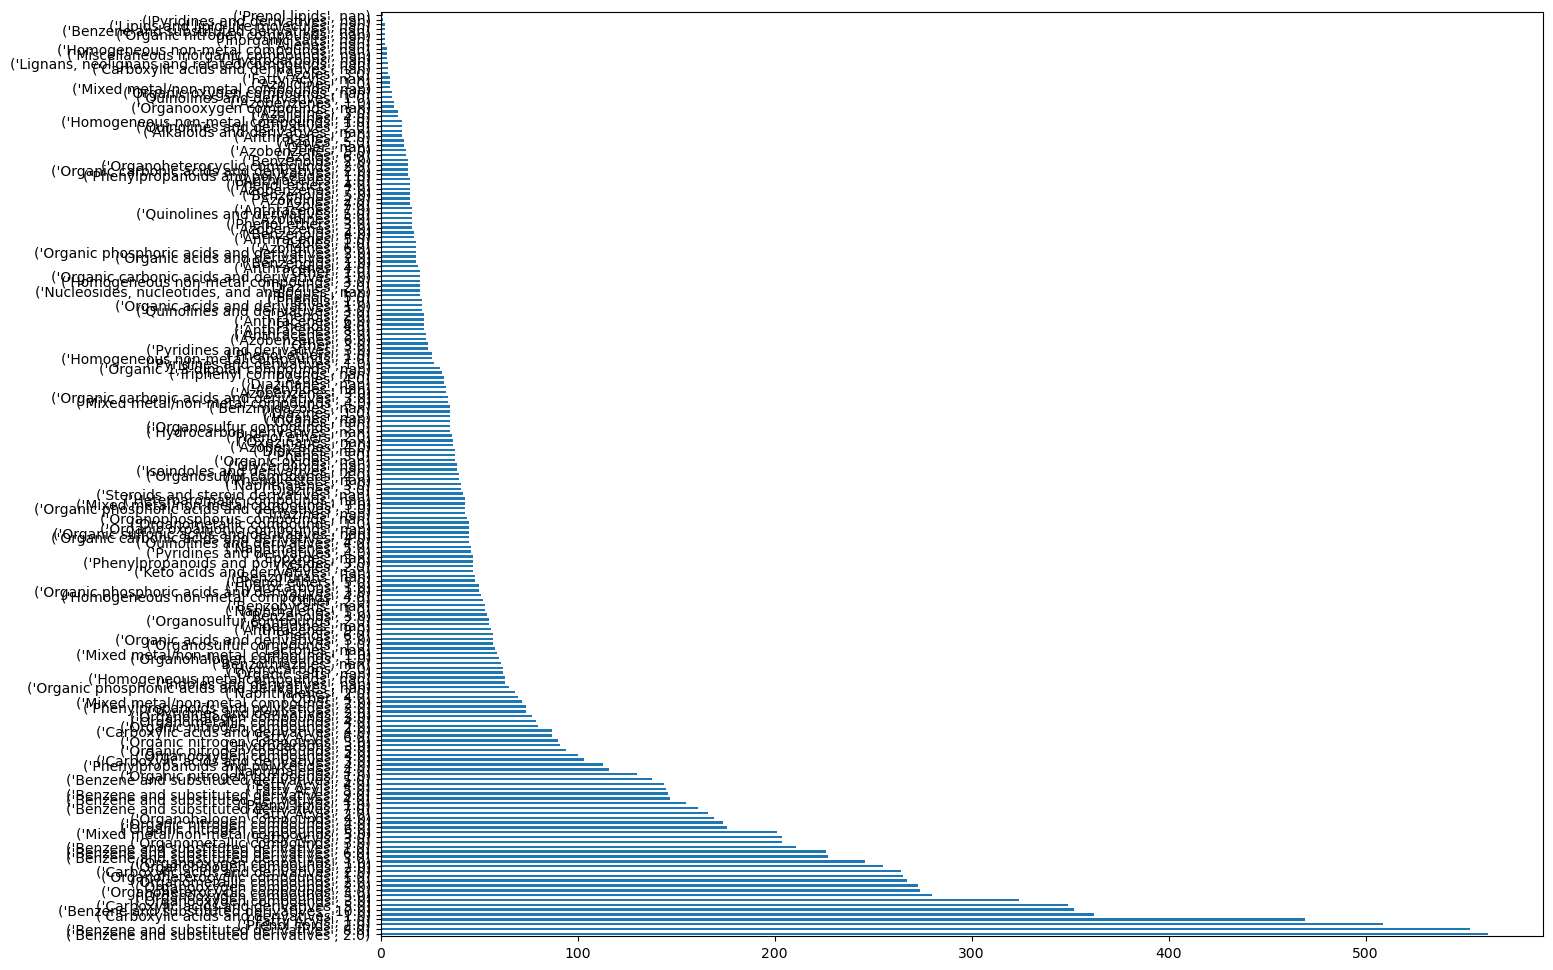

In [28]:
df.group_str.value_counts().plot.barh(figsize = (15,12))

In [22]:
df['final_picks'].value_counts()

1.0    318
Name: final_picks, dtype: int64

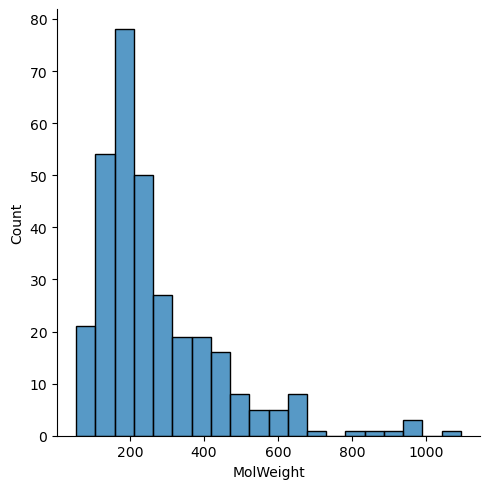

In [36]:
sns.displot(df[df['final_picks']==1]['MolWeight'])


[<BarContainer object of 47 artists>, <BarContainer object of 10 artists>]


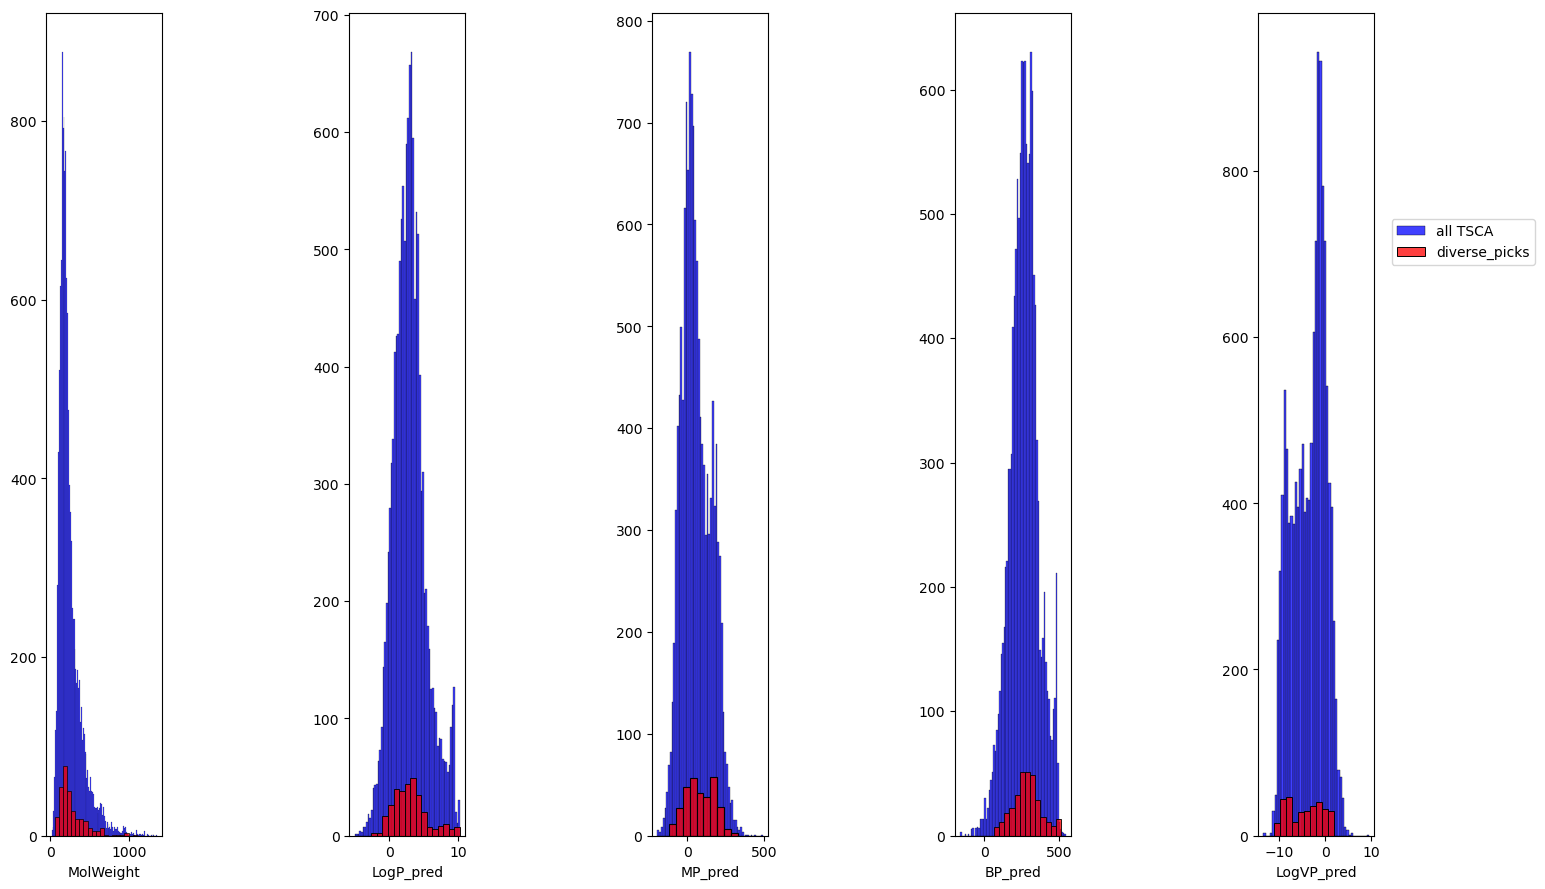

In [99]:
f = plt.figure(figsize = (20,9))
k=0
for n, e in enumerate( ['MolWeight','LogP_pred','MP_pred','BP_pred','LogVP_pred']):
    ax = plt.subplot(1,7, n+1)
    g = sns.histplot(df[e], color = 'b', ax = ax, label = 'all TSCA')
    g = sns.histplot(df[df['final_picks']==1][e], color = 'r', ax = ax, label = 'diverse_picks')
    ax.set_ylabel("")
    #plt.subplots_adjust(hspace = 0.8)
handles, labels = ax.get_legend_handles_labels()
print(handles)
l = plt.legend(handles[0:5], labels[0:5], bbox_to_anchor=(1.15,0.75), loc=2, borderaxespad=0.)
plt.tight_layout()
f.savefig(figures_dir+'Figure1.png', dpi = 300)    

In [70]:
MOLS = dict(zip(df['dtxsid'], df['smiles']))
MOLS = {k:Chem.MolFromSmiles(v) for k,v in MOLS.items()}
MOLS = {i:j for i,j in MOLS.items() if j}
FP0 = pd.DataFrame([np.array(AllChem.GetMorganFingerprintAsBitVect(i,3,1024)) for i in MOLS.values()])
FP0.index = MOLS.keys()
FP0.columns = ['mrgn_%d'%i for i in FP0.columns]

RDKit ERROR: [11:26:56] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [11:26:56] Explicit valence for atom # 4 O, 3, is greater than permitted
RDKit ERROR: [11:26:56] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [11:26:56] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [11:26:56] Explicit valence for atom # 2 O, 3, is greater than permitted
RDKit ERROR: [11:26:56] Explicit valence for atom # 10 N, 4, is greater than permitted
RDKit ERROR: [11:26:56] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [11:26:56] Explicit valence for atom # 0 O, 3, is greater than permitted
RDKit ERROR: [11:26:56] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [11:26:56] Explicit valence for atom # 8 O, 3, is greater than permitted
RDKit ERROR: [11:26:56] Explicit valence for atom # 0 O, 4, is greater than permitted
RDKit ERROR: [11:26:56] SMILES Parse Error: syntax er

In [81]:
FP0.shape

(14194, 1024)

In [75]:
df1 = df.set_index('dtxsid')

In [73]:
df[['final_picks', 'screenable']]

,final_picks,screenable
0,NaN,1
1,NaN,0
2,NaN,0
3,1.0,1
4,NaN,0
...,...,...
14242,NaN,1
14243,1.0,1
14244,NaN,1
14245,NaN,1


In [82]:
df2 = pd.concat([FP0, df1[['final_picks', 'screenable']]], axis = 1).dropna(subset=['mrgn_0'])

In [85]:
df2['final_picks'] = df2['final_picks'].replace(np.nan, 0)

In [86]:
from sklearn.manifold import TSNE

In [87]:
model = TSNE(learning_rate = 200, random_state = 42)

In [90]:
tsne_features = model.fit_transform(df2.iloc[:, :-2])

In [93]:
tsne_df=pd.concat([pd.DataFrame(tsne_features, index =df2.index, columns = ['tsne_x', 'tsne_y']), df2.iloc[:,-2:]],axis =1)

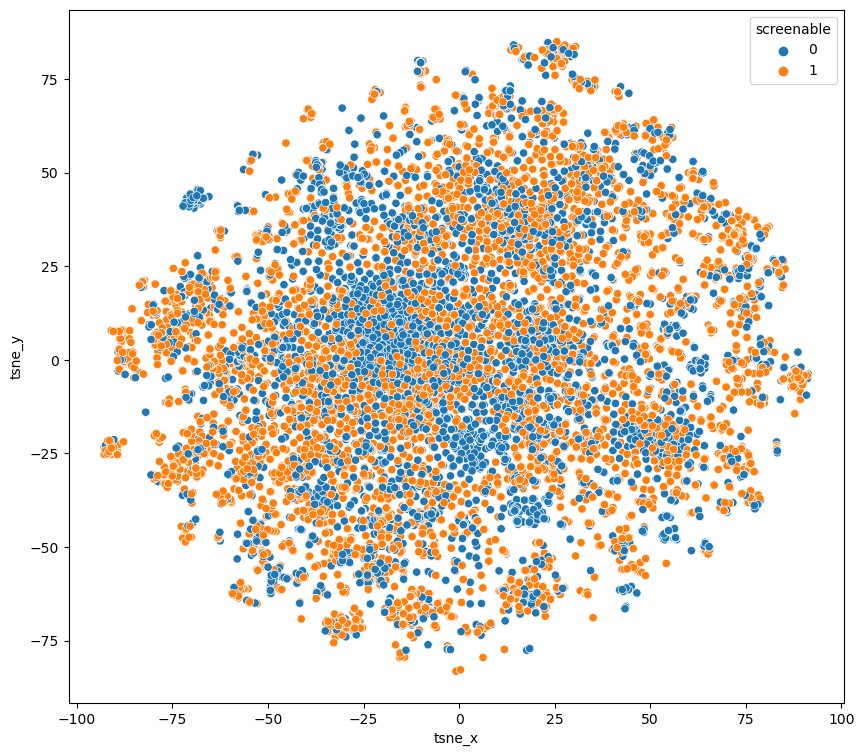

In [98]:
fig, ax = plt.subplots(figsize = (10,9))

ax = sns.scatterplot(x="tsne_x", y="tsne_y",
                     data=tsne_df, hue = 'screenable')
plt.savefig(figures_dir+'Figure2.png', dpi = 300)

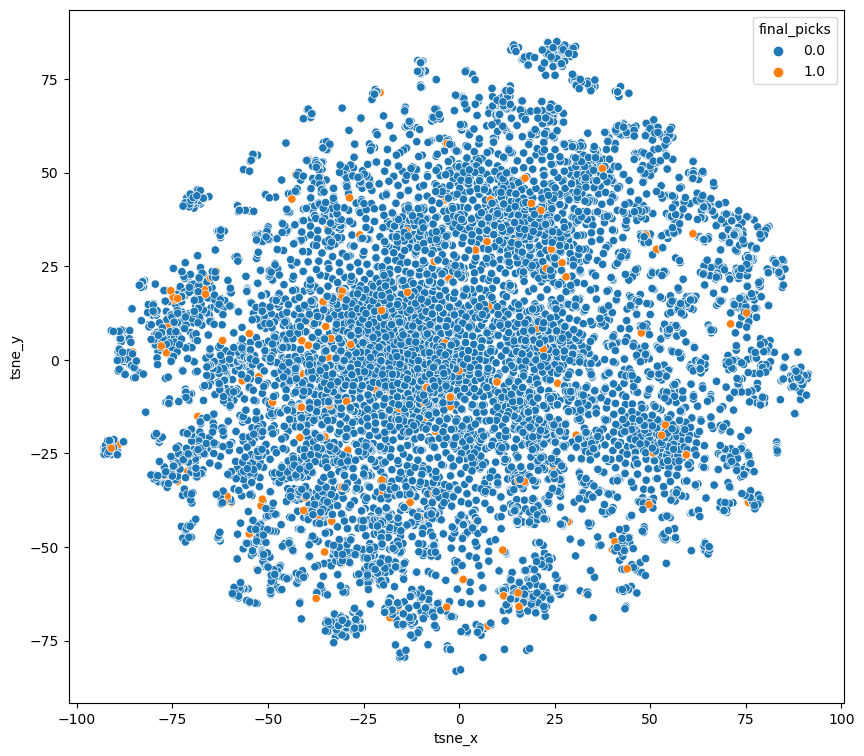

In [97]:
fig, ax = plt.subplots(figsize = (10,9))

ax = sns.scatterplot(x="tsne_x", y="tsne_y",
                     data=tsne_df, hue = 'final_picks')
plt.savefig(figures_dir+'Figure3.png', dpi = 300)

### DEREK alerts

In [100]:
derek_df = pd.read_csv(external_dir+'TSCA_Inv_DEREK.tsv',sep='\t',low_memory=False)

In [101]:
col_names = derek_df.columns.values
names_w_structure = len([a for a in col_names if "Structure" in a])
names_w_out_structure = [a for a in col_names if "Structure" not in a]
print(f'{names_w_structure} Contain substring "Structure" ')

print(f'{len(names_w_out_structure)} do NOT Contain substring "Structure" ')



0 Contain substring "Structure" 
915 do NOT Contain substring "Structure" 


In [102]:
derek_filtered = derek_df[~derek_df['SMILES'].str.contains('.',na=False,regex=False)].dropna(axis='columns',how='all')

In [103]:
n_rows_removed = derek_df.shape[0] - derek_filtered.shape[0]
n_columns_removed = derek_df.shape[1] - derek_filtered.shape[1]

In [104]:
print(f"{n_rows_removed} rows removed")
print(f"{n_columns_removed} columns removed")

0 rows removed
1 columns removed


In [105]:
a = set(derek_filtered.columns.values)
b = set(names_w_out_structure)
b-a

{'Unnamed: 914'}

In [107]:
derek_filtered.head(1)
derek_filtered_no_ec3 = derek_filtered.filter(regex='^(?!.*EC3)')
 

derek_filtered.to_csv(processed_dir+'derek_filtered.csv')

In [108]:

a = set(derek_filtered.columns.values)
b = set(derek_filtered_no_ec3.columns.values)

a-b

{'Skin sensitisation mammal Alert 1 Derek EC3 Model 2022.1 EC3 Dataset Certified',
 'Skin sensitisation mammal Alert 1 Derek EC3 Model 2022.1 EC3 Similar Compounds',
 'Skin sensitisation mammal Alert 1 Derek EC3 Model 2022.1 LLNA EC3 %',
 'Skin sensitisation mammal Alert 2 Derek EC3 Model 2022.1 EC3 Dataset Certified',
 'Skin sensitisation mammal Alert 2 Derek EC3 Model 2022.1 EC3 Similar Compounds',
 'Skin sensitisation mammal Alert 2 Derek EC3 Model 2022.1 LLNA EC3 %',
 'Skin sensitisation mammal Alert 3 Derek EC3 Model 2022.1 EC3 Dataset Certified',
 'Skin sensitisation mammal Alert 3 Derek EC3 Model 2022.1 EC3 Similar Compounds',
 'Skin sensitisation mammal Alert 3 Derek EC3 Model 2022.1 LLNA EC3 %',
 'Skin sensitisation mammal Most Potent EC3 Prediction',
 'Skin sensitisation mammal Tautomer 1 Alert 1 Derek EC3 Model 2022.1 EC3 Dataset Certified',
 'Skin sensitisation mammal Tautomer 1 Alert 1 Derek EC3 Model 2022.1 EC3 Similar Compounds',
 'Skin sensitisation mammal Tautomer 1 Al

In [109]:
cols = derek_filtered_no_ec3.columns.tolist()
to_remove = cols[2:28]
derek_alerts_reasoning = derek_filtered_no_ec3.loc[:, ~derek_filtered_no_ec3.columns.isin(to_remove)].copy()


In [110]:
derek_alerts_reasoning = derek_alerts_reasoning.drop_duplicates(subset = 'Compound Name')

In [111]:
derek_temp = derek_alerts_reasoning.filter(regex='Compound Name|Alert \d name|reasoning$')
derek_temp = derek_temp.filter(regex='^(?!.*sensitisation)')
derek_temp = derek_temp.filter(regex='^(?!.*Tautomer)')

derek_temp = derek_temp.set_index('Compound Name')

In [112]:
derek_alert_names = derek_temp.filter(regex='Alert \d name')  #ALERT NAMES

In [113]:
my_names = []
for column in derek_alert_names:
    names = derek_alert_names[column].values
    clean_names = [name for name in names if not pd.isna(name)]
    my_names.append(clean_names)

my_names = sum(my_names,[])
my_names = list(set(my_names))
len(my_names)

406

In [114]:
endpoint_names = [i.split(' Alert')[0] for i in derek_temp.filter(regex='Alert \d').columns.values]
unique_endpoints = list(set(endpoint_names))
conditions_list = []
endpoint_list = []

for endpoint in unique_endpoints:
    derek_endpoint_cols = derek_temp.filter(like=f'{endpoint}').filter(regex='reasoning$|Alert \d')
    derek_reasoning = derek_endpoint_cols.filter(regex='reasoning$')
    derek_alerts = derek_endpoint_cols.filter(regex='Alert \d')
    temp_list = []
    for col in derek_alerts:
        alert = derek_alerts.filter(items=[col])
        temp = pd.concat([alert,derek_reasoning],axis=1)
        temp = temp.dropna(how='any').values.tolist()
        [x.insert(0,endpoint) for x in temp]
        temp = [list(x) for x in set(tuple(x) for x in temp)]  #ignore; Removed duplicates, dupes removed at end
        temp_list.append(pd.DataFrame(temp))
    endpoint_conditions = pd.concat(temp_list,axis=0).drop_duplicates().reset_index(drop=True)
    if len(endpoint_conditions) > 0:
        conditions_list.append(endpoint_conditions)
        endpoint_list.append(derek_endpoint_cols.T)




total_conditions = sum([c.shape[0] for c in conditions_list])
print("Total Conditions:", total_conditions)

Total Conditions: 899


In [115]:
tables = []
for i in range(0,len(endpoint_list)):
    conditions = conditions_list[i]
    endpoint = endpoint_list[i]
    tmp =  pd.concat([conditions,endpoint],axis=1)
    n_conditions = conditions.shape[0]

    for i in range(n_conditions):
        row_condition = tmp.iloc[i,1:3].values.tolist()
        row_vals = tmp.iloc[i,0:3].values.tolist()
        for col in tmp.iloc[:,3:]:
            col_values = tmp[col].values[n_conditions:].tolist()
            cond_row = tmp.iloc[i]
            if all(vals in col_values for vals in row_condition):
                row_vals.append(1)
            else:
                row_vals.append(0)
        tmp.iloc[i] = row_vals
    cond_table = tmp.head(conditions.shape[0])
    tables.append(cond_table)



In [116]:
final_table = pd.concat(tables)

In [117]:
final_table

,0,1,2,DTXSID3060164,DTXSID7060837,DTXSID9025879,DTXSID2026282,DTXSID4052188,DTXSID4025242,DTXSID10862055,...,DTXSID7061805,DTXSID4062519,DTXSID00893636,DTXSID9063956,DTXSID7065546,DTXSID5064209,DTXSID7062873,DTXSID9040342,DTXSID3044889,DTXSID3060667
0,Nephrotoxicity mammal,"1,2-Ethylenediamine",EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nephrotoxicity mammal,Hydrazine,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nephrotoxicity mammal,para-Aminophenol or derivative,PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Nephrotoxicity mammal,Dithiocarbamate,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Nephrotoxicity mammal,"Pyrazolidine-3,5-dione or pyrazolone derivative",PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Blood in urine mammal,Acyclovir-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Blood in urine mammal,Diflunisal-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Blood in urine mammal,Oxyphenbutazone-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Blood in urine mammal,Indomethacin-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [130]:
final_table.rename(columns = {0: 'endpoint', 1: 'toxicophore', 2: 'confidence'}, inplace = True)

In [131]:
final_table.to_csv(interim_dir+'Derek_processed_150423.csv')

In [132]:
final_table

,endpoint,toxicophore,confidence,DTXSID3060164,DTXSID7060837,DTXSID9025879,DTXSID2026282,DTXSID4052188,DTXSID4025242,DTXSID10862055,...,DTXSID7061805,DTXSID4062519,DTXSID00893636,DTXSID9063956,DTXSID7065546,DTXSID5064209,DTXSID7062873,DTXSID9040342,DTXSID3044889,DTXSID3060667
0,Nephrotoxicity mammal,"1,2-Ethylenediamine",EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Nephrotoxicity mammal,Hydrazine,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Nephrotoxicity mammal,para-Aminophenol or derivative,PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Nephrotoxicity mammal,Dithiocarbamate,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Nephrotoxicity mammal,"Pyrazolidine-3,5-dione or pyrazolone derivative",PLAUSIBLE,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,Blood in urine mammal,Acyclovir-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Blood in urine mammal,Diflunisal-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Blood in urine mammal,Oxyphenbutazone-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Blood in urine mammal,Indomethacin-like,EQUIVOCAL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [133]:
ft_copy = final_table.copy()

In [144]:
ft_copy2.iloc[:,8].value_counts()

0    13286
1       13
Name: (Androgen receptor modulation mammal, Quinoline or analogue), dtype: int64

<AxesSubplot:>

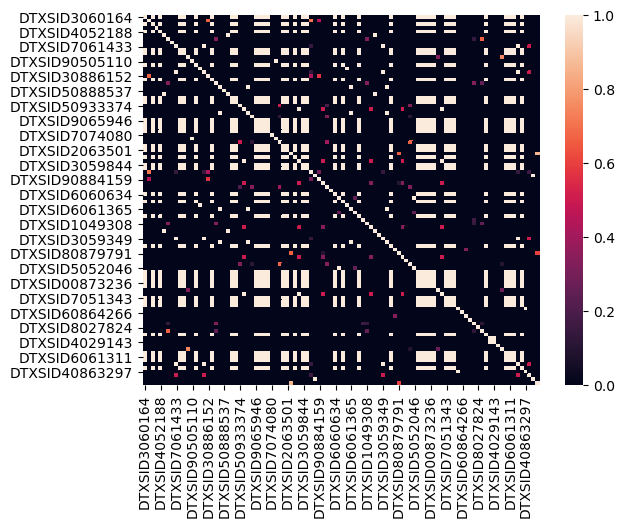

In [147]:
sns.heatmap(S_react.iloc[:100,:100])

<AxesSubplot:>

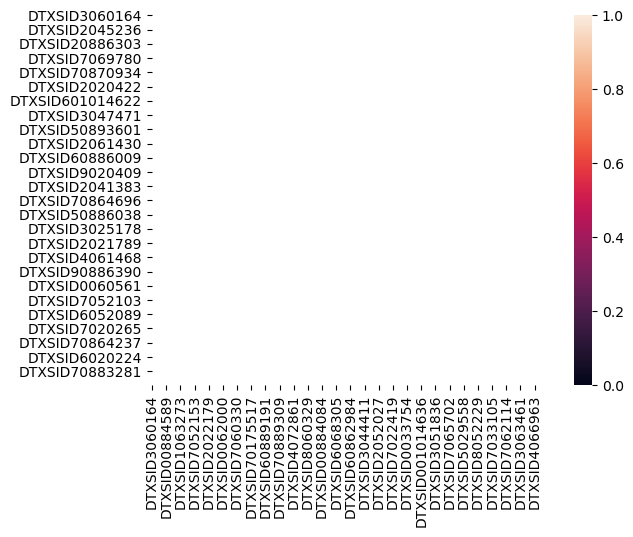

In [148]:
sns.heatmap(S_react)

<AxesSubplot:>

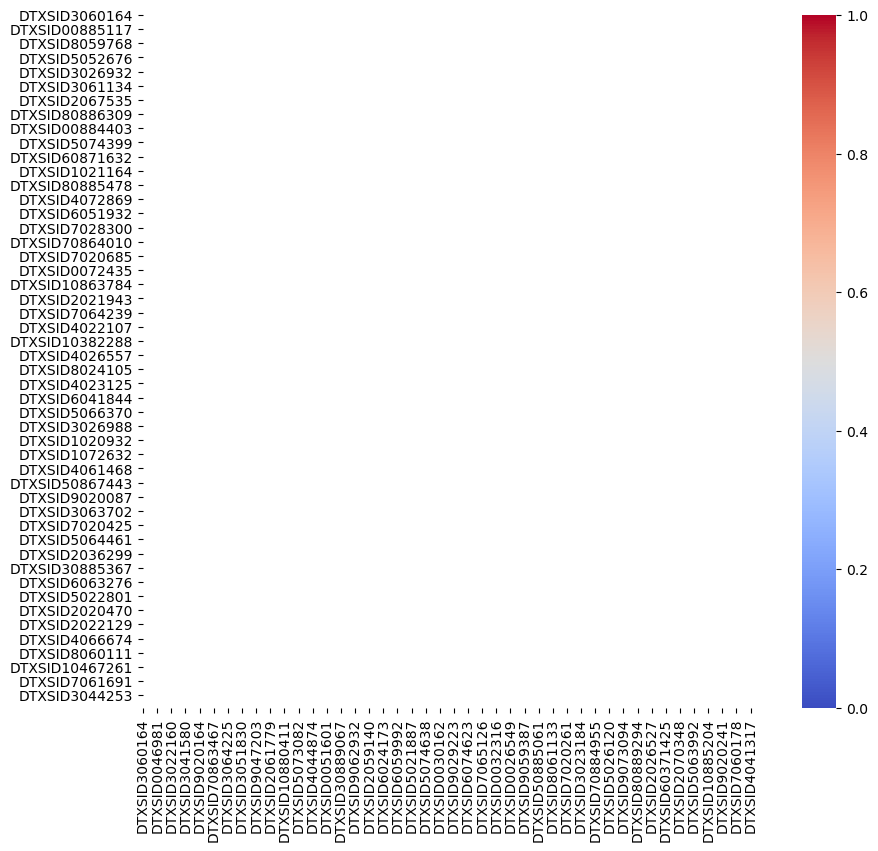

In [134]:
ft_copy = ft_copy.drop(['confidence'], axis = 1)
ft_copy = ft_copy.groupby(['endpoint', 'toxicophore']).agg(lambda x: x.sum())
ft_copy2 = ft_copy.T
# scipy
from scipy.spatial.distance import pdist, squareform
D_react = pd.DataFrame(squareform(pdist(ft_copy2, 'jaccard')), columns = ft_copy2.index, index = ft_copy2.index)
S_react = 1- D_react

plt.figure(figsize = (10,9))
sns.heatmap(S_react, cmap = 'coolwarm')

In [135]:
S_react.to_csv(interim_dir+'Derek_Sim.csv')